# Music Genre Classifier 

This notebook deals with a multiclass classification problem regarding music genres of audio tracks.

The used datasets are downloaded from kaggle and contain features extracted from the sound waves of 30 seconds long 16-bit audio trakcs.

The goal of the notebook is to train a machine learning model that classifies correctly the music genre of a track given its features; it is important to notice that musical genres are defined by a set of conventions, they are not naturally determined, this may affect negatively the performance of the models developed in this notebook. 

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from scipy.stats import loguniform, beta, uniform, randint


## Setting up some functions

In [2]:
def plot_learning_curve(model, X, y, scoring_metric:str):
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                       X=X,
                                                       y=y,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = scoring_metric,
                                                       shuffle = False)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    fig=plt.figure(figsize=(12,7))
    train_std = np.std(train_scores, axis=1)
    ax = fig.add_subplot()
    ax.plot(train_sizes, train_mean,
            color='blue', marker='+',        
            markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes,       
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')
        
    ax.plot(train_sizes, test_mean,
                 color='green', linestyle='--',
                 marker='d', markersize=5,
             label='Validation accuracy')
        
    ax.fill_between(train_sizes,
                         test_mean + test_std,
                         test_mean - test_std,
                     alpha=0.15, color='green')       
    ax.grid()
    ax.set_xlabel('Training set size')
    ax.set_ylabel('F1-score')
    ax.legend(loc='lower right')
    ax.set_title(model['classifier'])
    ax.set_ylim([0.60, 1.03])

In [3]:
def get_f1_scorings(model, X, y):
    # Define cross-validation strategy (stratified k-fold)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define evaluation metrics
    scoring = ['f1_weighted', 'f1_micro', 'f1_macro']
    
    # Perform cross-validation and compute evaluation metrics
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    
    # Extract and print evaluation results
    print("F1 weighted:", cv_results['test_f1_weighted'].mean())
    print("F1 micro:", cv_results['test_f1_micro'].mean())
    print("F1 macro:", cv_results['test_f1_macro'].mean())

In [4]:
def compute_ratio(y_expected, y_predicted):
    np.set_printoptions(precision=2)
    matrix = confusion_matrix(y_expected, y_predicted)
    score = accuracy_score(y_expected, y_predicted)

    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    TN = matrix[0,0]

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
    # Sensitivity or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
        
    print("Accuracy:   %0.3f" % score)    
    print("Specificity or true negative rate (AVG):   %0.3f" % TNR)
    print("Sensitivity or true positive rate (AVG):   %0.3f" % TPR)

## Importing datasets


I start importing two datasets from two different files downloaded from the kaggle website 

(link: https://www.kaggle.com/datasets/insiyeah/musicfeatures?resource=download )

In [5]:
first_dataset = pd.read_csv('data/data.csv')
second_dataset = pd.read_csv('data/data_2genre.csv')

In [6]:
first_dataset.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [7]:
second_dataset.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,pop.00024.au,117.453835,57,0.410990,0.207584,3301.781785,3175.656592,7302.597509,0.144527,-40.802069,...,-0.568772,0.552448,-1.981371,1.915755,0.076505,-1.270496,1.233082,1.493700,0.949931,1
1,pop.00099.au,78.302557,38,0.360462,0.138195,2765.747194,3222.713605,6873.391771,0.096015,-119.320605,...,1.566938,-2.932391,-1.609138,-0.200545,-2.429376,1.207988,5.848729,1.609469,7.580263,1
2,pop.00009.au,107.666016,50,0.454810,0.159711,3279.877315,3026.391118,6953.099622,0.172819,-35.277026,...,-0.518891,0.212918,-1.294660,-0.105626,-1.245879,-2.528455,0.571032,1.569434,-1.724873,1
3,pop.00078.au,103.359375,52,0.454698,0.223419,3124.176350,2970.320532,6618.134981,0.142721,-42.757179,...,3.020176,-1.242321,-3.524069,-0.325165,-1.443294,-1.864617,-0.031307,-0.729631,-0.987611,1
4,pop.00037.au,103.359375,51,0.451668,0.240985,3236.413205,2953.596262,6698.776160,0.164825,4.821123,...,1.753352,3.336132,2.352307,1.428845,-0.604926,-2.185691,-1.602394,-0.612146,-4.050126,1


Now, I check the differences in the two datasets, in particular I want to know if the schema of the two is different. So I list the 

In [8]:
list(np.setdiff1d(first_dataset.columns, second_dataset.columns))

[]

Since my research shows that there is no difference in the schema of the two datasets I concatenate them consindering a single complete dataset

In [9]:
data = pd.concat([first_dataset, second_dataset])
data.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [10]:
print(f'The first dataset has {len(first_dataset)} rows, the second one {len(second_dataset)}')
print(f'Hence, the final dataset has {len(data)} rows')

The first dataset has 1000 rows, the second one 200
Hence, the final dataset has 1200 rows


## Exploratory Data Analysis

### Missing Values

At first I look for missing values in each of the rows

In [11]:
data.isnull().sum(axis=0)

filename              0
tempo                 0
beats                 0
chroma_stft           0
rmse                  0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
label                 0
dtype: int64

### Label analysis and class balance

As shown there is no missing value, so I proceed to check class balance on the label column

In [12]:
data['label'].value_counts()

1            100
2            100
jazz         100
reggae       100
blues        100
hiphop       100
pop          100
disco        100
rock         100
classical    100
country      100
metal        100
Name: label, dtype: int64

There seem to be two labels which cannot be reconducted to a real music genre, the '1' and the '2' labels

In [13]:
data.loc[data['label'] == 1].head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,pop.00024.au,117.453835,57,0.410990,0.207584,3301.781785,3175.656592,7302.597509,0.144527,-40.802069,...,-0.568772,0.552448,-1.981371,1.915755,0.076505,-1.270496,1.233082,1.493700,0.949931,1
1,pop.00099.au,78.302557,38,0.360462,0.138195,2765.747194,3222.713605,6873.391771,0.096015,-119.320605,...,1.566938,-2.932391,-1.609138,-0.200545,-2.429376,1.207988,5.848729,1.609469,7.580263,1
2,pop.00009.au,107.666016,50,0.454810,0.159711,3279.877315,3026.391118,6953.099622,0.172819,-35.277026,...,-0.518891,0.212918,-1.294660,-0.105626,-1.245879,-2.528455,0.571032,1.569434,-1.724873,1
3,pop.00078.au,103.359375,52,0.454698,0.223419,3124.176350,2970.320532,6618.134981,0.142721,-42.757179,...,3.020176,-1.242321,-3.524069,-0.325165,-1.443294,-1.864617,-0.031307,-0.729631,-0.987611,1
4,pop.00037.au,103.359375,51,0.451668,0.240985,3236.413205,2953.596262,6698.776160,0.164825,4.821123,...,1.753352,3.336132,2.352307,1.428845,-0.604926,-2.185691,-1.602394,-0.612146,-4.050126,1


In [14]:
data.loc[data['label'] == 2].head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
100,classical.00091.au,92.285156,44,0.223738,0.044746,2192.798091,1911.986037,4066.467077,0.152438,-251.313450,...,10.469501,-4.921158,5.283192,0.307727,3.319733,1.261333,4.767063,-2.076303,1.128967,2
101,classical.00037.au,161.499023,65,0.284173,0.041551,1534.064978,1464.710723,2838.224504,0.093952,-275.346266,...,-8.020302,-5.155060,-4.618427,0.714935,6.517703,5.906553,2.683813,-2.032035,-8.060386,2
102,classical.00071.au,143.554688,69,0.208113,0.051705,1396.824265,1574.218758,2615.059187,0.075857,-269.665355,...,-3.146819,1.640978,0.676201,1.898461,2.231277,-2.128317,-3.663709,-1.074120,3.530190,2
103,classical.00056.au,95.703125,43,0.312900,0.189937,1680.088264,1706.919816,3077.806389,0.096726,-81.103742,...,1.934638,-10.066493,0.944550,-3.573206,-6.168349,-8.033391,3.775875,-5.029609,-0.853512,2
104,classical.00047.au,123.046875,62,0.258572,0.009498,1173.658308,1517.285384,2082.504074,0.066325,-436.837165,...,-2.783275,-5.234963,-7.386918,-6.992792,-3.200490,-0.358716,2.217817,2.568618,4.471460,2


The data shows that the label '1' maps to the pop genre, while the label '2' is associated to the classical genre, so I apply a mapping on the 'label' column on the whole dataset to set the correct labels

In [15]:
data['label'] = data['label'].replace(to_replace={1:'pop', 2:'classical'})

In [16]:
data['label'].value_counts()

pop          200
classical    200
jazz         100
reggae       100
blues        100
hiphop       100
disco        100
rock         100
country      100
metal        100
Name: label, dtype: int64

Now the dataset seems to be slightly unbalanced towards the 'classical' and the 'pop' genre. This will be dealt with later.

In [17]:
X = data.drop('label', axis=1)
y = data['label']

### Feature correlation

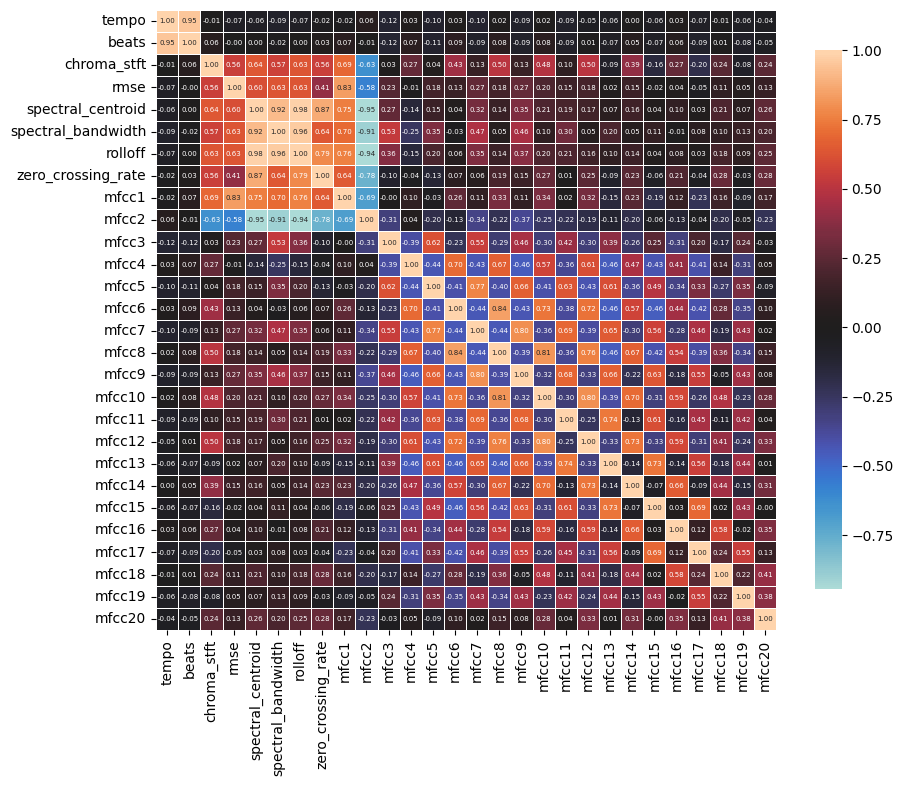

In [18]:
corr = X.drop('filename', axis=1).corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, fmt='.2f', vmax=1.0, annot=True, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .70}, annot_kws={"fontsize":5})
plt.show()

### General feature informations

In [19]:
X.describe()

,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,119.650771,56.882500,0.370632,0.129331,2203.833135,2246.295208,4571.216473,0.103968,-152.721641,100.395629,...,-5.694288,3.696146,-4.212006,1.364958,-3.308531,0.962490,-3.322924,0.514315,-1.958679,-0.975615
std,28.595204,14.484769,0.084014,0.070874,767.091516,580.235661,1721.201024,0.041925,111.544452,33.575997,...,6.578539,6.660127,6.032812,4.979126,4.870773,4.520644,4.674349,3.836801,3.770014,3.781028
min,54.978391,18.000000,0.171782,0.005276,569.930721,897.994319,749.062137,0.021701,-552.064063,-1.527148,...,-28.052265,-15.805227,-27.542309,-12.598773,-17.545474,-15.693589,-17.227765,-11.975698,-18.504188,-19.935203
25%,99.384014,47.000000,0.304514,0.079168,1548.496850,1815.497242,3172.968313,0.070809,-217.159272,74.875960,...,-10.095268,-0.967632,-8.376523,-2.048828,-6.514669,-2.005988,-6.667356,-2.003979,-4.405887,-3.272533
50%,117.453835,55.000000,0.376657,0.122036,2192.798091,2223.270960,4603.684662,0.099478,-121.409818,98.738478,...,-5.505038,2.979597,-3.621954,1.351666,-3.007097,0.966397,-3.201921,0.665095,-1.902843,-0.985806
75%,135.999178,65.000000,0.432291,0.182267,2753.175473,2664.676118,5679.811488,0.132843,-69.786929,123.917582,...,-0.868188,8.714135,0.388630,4.696107,0.068461,3.994902,-0.089599,3.021267,0.620840,1.381480
max,234.907670,117.000000,0.663573,0.398012,4434.439444,3509.578677,8676.405868,0.274829,42.034587,193.096518,...,17.421038,23.037571,13.054333,18.161663,12.357588,13.468803,11.489994,15.379257,14.686910,15.368966


In [20]:
X.nunique(axis=0)

filename              1000
tempo                   35
beats                   81
chroma_stft            986
rmse                   986
spectral_centroid      986
spectral_bandwidth     986
rolloff                986
zero_crossing_rate     985
mfcc1                  986
mfcc2                  986
mfcc3                  986
mfcc4                  986
mfcc5                  986
mfcc6                  986
mfcc7                  986
mfcc8                  986
mfcc9                  986
mfcc10                 986
mfcc11                 986
mfcc12                 986
mfcc13                 986
mfcc14                 986
mfcc15                 986
mfcc16                 986
mfcc17                 986
mfcc18                 986
mfcc19                 986
mfcc20                 986
dtype: int64

## Preprocessing

I apply label encoding to the 'label' column in order to transform its data from a string format to an integer format. This is fundamental to the application of some kind of algorithms, such as xgboost, which only deals with numerical targets 

In [21]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
name_mapping = dict(zip(np.unique(y), label_encoder.classes_))
name_mapping

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

### Train-Test Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

### Column Transformer definition

There is no missing value and, except for the filename, all the features are numeral, so I can apply a StandardTransformer to all of them in order to scale them up and normalize them and drop the 'filename' column which is uninformative for my scopes

In [ ]:
column_tf = ColumnTransformer(transformers=[
    ('std_transformer', StandardScaler(), list(X.drop('filename', axis=1).columns))
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0)

I could apply a noise generating function to the dataset in order to insert some missing values in it and add to the ColumnTransformer some kind of imputer which would be applied to the columns affected from the noise generation.

Though, I preferred to keep a clean dataset due to its small dimensions. Generating noise in an already small dataset may have an important effect on the model's performance, so I prefer to preserve the performance of my model.

If I had to impute any missing value in the dataset I would probably use a KNNImputer to preserve the variance of each feature.

## Initial model testing

I start by instantiating a base model which only scales all of the features and predicts the label.

In a first instance I exploit the standard multiclass implementation of a Logistic Regressor already present in SKLearn.

In [ ]:
base_model = Pipeline([
    ('transformer', column_tf),
    ('classifier', LogisticRegression(solver='lbfgs', penalty='l2', C=1, max_iter=1000))
])
base_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('std_transformer',
                                                  StandardScaler(),
                                                  ['tempo', 'beats',
                                                   'chroma_stft', 'rmse',
                                                   'spectral_centroid',
                                                   'spectral_bandwidth',
                                                   'rolloff',
                                                   'zero_crossing_rate',
                                                   'mfcc1', 'mfcc2', 'mfcc3',
                                                   'mfcc4', 'mfcc5', 'mfcc6',
                                                   'mfcc7', 'mfcc8', 'mfcc9',
                                                   'mfcc10', 'mfcc11', 'mfcc12',
                                                   'mfcc13', 'mfcc14', 'mfcc15',
                                                   'mfcc16', 'mfcc17', 'mfcc18',
                                                   'mfcc19', 'mfcc20'])],
                                   verbose_feature_names_out=False)),
                ('classifier', LogisticRegression(C=1, max_iter=1000))])

In [ ]:
y_pred = base_model.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, average='macro')

0.6179171112252121

Now I manually implement instead a One vs All approach still using the LogisticRegression and also trying with the KNeighborClassifier

In [ ]:
ova_log_pipeline = OneVsRestClassifier(Pipeline([
    ('transformer', column_tf),
    ('clf', LogisticRegression())
]))
ova_log_pipeline.fit(X_train, y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('transformer',
                                               ColumnTransformer(sparse_threshold=0,
                                                                 transformers=[('std_transformer',
                                                                                StandardScaler(),
                                                                                ['tempo',
                                                                                 'beats',
                                                                                 'chroma_stft',
                                                                                 'rmse',
                                                                                 'spectral_centroid',
                                                                                 'spectral_bandwidth',
                                                                                 'rolloff',
                                                                                 'zero_crossing_rate',
                                                                                 'mfcc1',
                                                                                 'mfcc2',
                                                                                 'mfcc3',
                                                                                 'mfcc4',
                                                                                 'mfcc5',
                                                                                 'mfcc6',
                                                                                 'mfcc7',
                                                                                 'mfcc8',
                                                                                 'mfcc9',
                                                                                 'mfcc10',
                                                                                 'mfcc11',
                                                                                 'mfcc12',
                                                                                 'mfcc13',
                                                                                 'mfcc14',
                                                                                 'mfcc15',
                                                                                 'mfcc16',
                                                                                 'mfcc17',
                                                                                 'mfcc18',
                                                                                 'mfcc19',
                                                                                 'mfcc20'])],
                                                                 verbose_feature_names_out=False)),
                                              ('clf', LogisticRegression())]))

In [ ]:
y_pred = ova_log_pipeline.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.620399360182865

In [ ]:
ova_kneigh_pipeline = OneVsRestClassifier(Pipeline([
    ('transformer', column_tf),
    ('clf', KNeighborsClassifier(n_neighbors=3))
]))
ova_kneigh_pipeline.fit(X_train, y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('transformer',
                                               ColumnTransformer(sparse_threshold=0,
                                                                 transformers=[('std_transformer',
                                                                                StandardScaler(),
                                                                                ['tempo',
                                                                                 'beats',
                                                                                 'chroma_stft',
                                                                                 'rmse',
                                                                                 'spectral_centroid',
                                                                                 'spectral_bandwidth',
                                                                                 'rolloff',
                                                                                 'zero_crossing_rate',
                                                                                 'mfcc1',
                                                                                 'mfcc2',
                                                                                 'mfcc3',
                                                                                 'mfcc4',
                                                                                 'mfcc5',
                                                                                 'mfcc6',
                                                                                 'mfcc7',
                                                                                 'mfcc8',
                                                                                 'mfcc9',
                                                                                 'mfcc10',
                                                                                 'mfcc11',
                                                                                 'mfcc12',
                                                                                 'mfcc13',
                                                                                 'mfcc14',
                                                                                 'mfcc15',
                                                                                 'mfcc16',
                                                                                 'mfcc17',
                                                                                 'mfcc18',
                                                                                 'mfcc19',
                                                                                 'mfcc20'])],
                                                                 verbose_feature_names_out=False)),
                                              ('clf',
                                               KNeighborsClassifier(n_neighbors=3))]))

In [ ]:
y_pred = ova_kneigh_pipeline.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.6098557898324951

These simple models averaged an f1_macro score of 0.61.

The aim of the next part of the notebook will be to build a more complex model in order to improve this performance

## Model selection


The model I instantiate is composed as follows:

- 'transformer', handling data preprocessing

- 'sampler', with the role of balancing the presence of each class in the dataset

- 'dim_reduction', for dimensionality reduction

- 'classifier', classification algorithm

In [ ]:
model_pipeline = IMBPipeline([
    ('transformer', column_tf),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA()),
    ('classifier', Perceptron())
])

Check wether the code runs smoothly to begin

In [ ]:
model_pipeline.fit(temp_X, y_train)

Pipeline(steps=[('sampler', SMOTE()),
                ('transformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('std_transformer',
                                                  StandardScaler(),
                                                  ['tempo', 'beats',
                                                   'chroma_stft', 'rmse',
                                                   'spectral_centroid',
                                                   'spectral_bandwidth',
                                                   'rolloff',
                                                   'zero_crossing_rate',
                                                   'mfcc1', 'mfcc2', 'mfcc3',
                                                   'mfcc4', 'mfcc5', 'mfcc6',
                                                   'mfcc7', 'mfcc8', 'mfcc9',
                                                   'mfcc10', 'mfcc11', 'mfcc12',
                                                   'mfcc13', 'mfcc14', 'mfcc15',
                                                   'mfcc16', 'mfcc17', 'mfcc18',
                                                   'mfcc19', 'mfcc20'])],
                                   verbose_feature_names_out=False)),
                ('dim_reduction', PCA()), ('classifier', Perceptron())])

In [ ]:
model_pipeline.predict(X_test)

array([4, 7, 7, 8, 1, 7, 7, 0, 0, 8, 0, 1, 7, 4, 7, 7, 1, 6, 7, 0, 4, 9,
       1, 9, 1, 7, 2, 5, 6, 3, 8, 0, 8, 5, 1, 2, 9, 7, 1, 3, 1, 4, 7, 7,
       6, 6, 7, 7, 8, 7, 0, 0, 7, 5, 8, 1, 4, 1, 4, 1, 1, 6, 4, 5, 9, 6,
       1, 9, 8, 1, 9, 4, 3, 2, 7, 3, 8, 7, 7, 6, 2, 1, 1, 0, 6, 7, 7, 3,
       3, 0, 7, 8, 9, 4, 1, 5, 4, 5, 2, 2, 9, 3, 7, 3, 4, 9, 7, 7, 1, 5,
       3, 7, 9, 7, 8, 1, 7, 8, 3, 3, 1, 3, 9, 6, 1, 2, 7, 2, 3, 5, 8, 9,
       0, 1, 7, 1, 4, 6, 3, 9, 2, 7, 9, 2, 3, 7, 9, 2, 3, 0, 8, 7, 4, 7,
       0, 2, 3, 1, 5, 2, 1, 1, 1, 8, 4, 8, 8, 0, 7, 0, 8, 9, 6, 4, 6, 2,
       2, 7, 6, 5, 6, 6, 9, 6, 8, 8, 1, 7, 0, 1, 7, 2, 9, 1, 0, 1, 3, 1,
       9, 4, 1, 6, 0, 1, 9, 1, 1, 5, 7, 1, 2, 3, 8, 1, 7, 3, 5, 0, 9, 3,
       8, 4, 8, 1, 8, 9, 8, 2, 6, 6, 9, 2, 0, 3, 6, 6, 9, 5, 0, 1, 7, 1,
       2, 6, 5, 4, 1, 8, 6, 3, 8, 1, 8, 8, 9, 0, 1, 1, 1, 9, 5, 9, 6, 3,
       7, 1, 5, 0, 2, 8, 6, 9, 7, 2, 4, 9, 1, 6, 6, 7, 3, 9, 7, 3, 9, 1,
       1, 4, 6, 8, 8, 5, 6, 7, 4, 1, 0, 6, 4, 0, 5,

### Nested cross-validation

Now I setup the possible configurations

In [ ]:
sampler_configs = [
    {
        'sampler' : [None]
    },
    {
        'sampler' : [SMOTE()],
        'sampler__sampling_strategy' : ['minority', 'all', 'not majority']
    },
    {
        'sampler' : [RandomOverSampler()],
        'sampler__sampling_strategy' : ['minority', 'all', 'not majority']
    }
]
dim_reduction_configs = [
    {
        'dim_reduction' : [None]
    },
    {
        'dim_reduction' : [PCA()] ,
        'dim_reduction__n_components' : [.5, .6, .7, .8, .9]
    },
    {
        'dim_reduction' : [LDA()]
    },
    {
        'dim_reduction' : [SFS(estimator=Perceptron(), cv=None, scoring='f1_macro')],
        'dim_reduction__estimator' : [Perceptron(), LogisticRegression(max_iter=10000), KNeighborsClassifier()],
        'dim_reduction__k_features' : randint(2, len(X.columns) - 2)
    }
]
classifier_configs = [
    {
        'classifier' : [LogisticRegression(max_iter=5000)],
        'classifier__solver' : ['lbfgs', 'saga'],
        'classifier__C' : loguniform(.001, 100)
    },
    {
        'classifier' : [KNeighborsClassifier()],
        'classifier__n_neighbors' : [3, 5, 7, 9]
    },
    {
        'classifier' : [DecisionTreeClassifier()],
        'classifier__max_depth' : randint(2, len(X.columns) - 10)
    },
    {
        'classifier' : [SVC()],
        'classifier__C': loguniform(.001, 100),
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__gamma': ['scale', 'auto', 0.1, 1, 10],
        'classifier__degree': [2, 3, 4],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__decision_function_shape': ['ovo', 'ovr']
    },
    {
        'classifier' : [RandomForestClassifier(n_jobs=-1)],
        'classifier__n_estimators' : randint(100, 1000),
        'classifier__max_depth':randint(3, 10),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 20),
        'classifier__max_features': uniform(0.1, 0.9)
    },
    {
        'classifier' : [xgb.XGBClassifier(n_jobs=-1)],
        'classifier__n_estimators': randint(100, 1000),
        'classifier__max_depth': randint(3, 10),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__subsample': uniform(0.6, 0.4),
        'classifier__colsample_bytree':  uniform(0.6, 0.4),
        'classifier__gamma': uniform(0, 0.5)
    }
]

In [ ]:
all_configs = [dict(itertools.chain(*(e.items()
for e in configuration)))
for configuration in
itertools.product(sampler_configs, dim_reduction_configs,classifier_configs)]

In [ ]:
len(all_configs)

72

In [ ]:
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv=2,
    scoring="f1_macro",
)

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
scores = cross_validate(rs, X_train, y_train, scoring='f1_macro', cv = outer_cv, return_estimator=True, verbose=3, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 15.6min remaining: 23.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 26.4min finished


In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

SMOTE(sampling_strategy='all')
None
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6890807168936758, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.08200545848825352,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1398147901910784,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=906, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...) {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'cols

In [ ]:
for estimator in scores['estimator']:
    estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9988094630678437, F1 on test set:0.7187234763560505
F1 on training set:0.9988094630678437, F1 on test set:0.7394089587098678
F1 on training set:0.7520646811053386, F1 on test set:0.6526275029566361
F1 on training set:0.7594222214474649, F1 on test set:0.6558902914158491
F1 on training set:0.9928675525442313, F1 on test set:0.7415800385407203


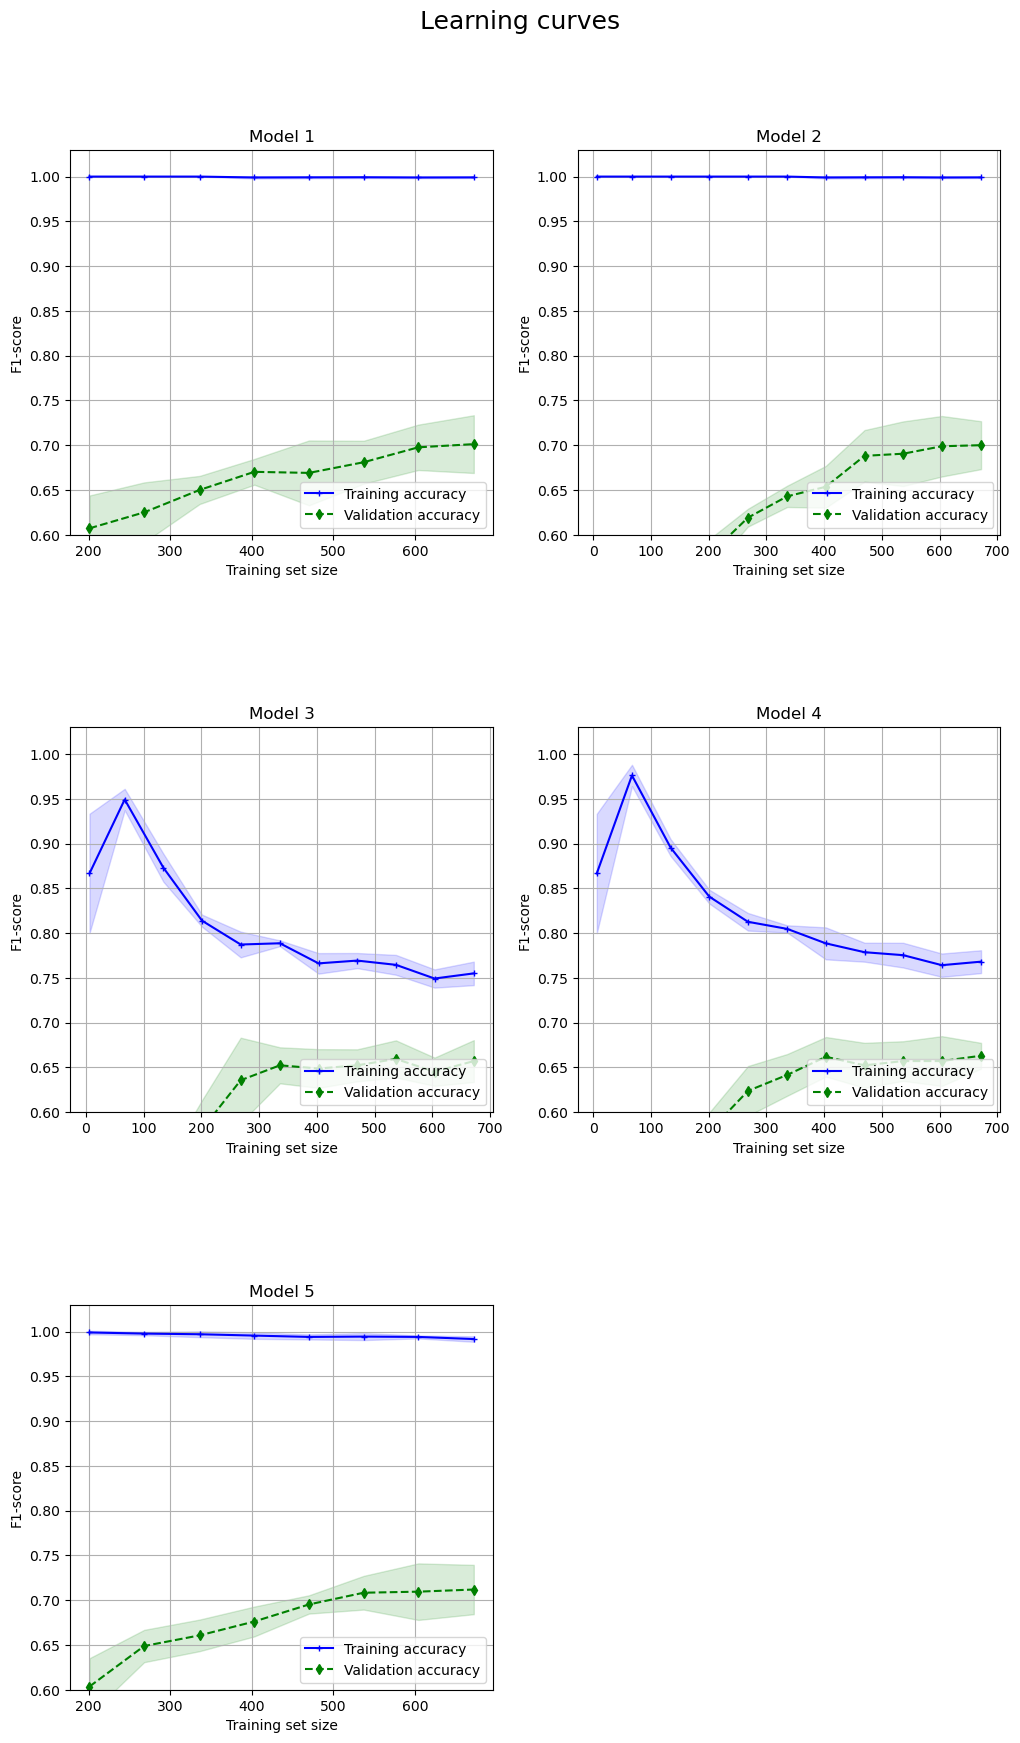

In [ ]:
fig = plt.figure(figsize=(12,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Learning curves", fontsize=18, y=0.95)
for index, estimator in enumerate(scores['estimator']):
    train_sizes, train_scores, test_scores = learning_curve(estimator.best_estimator_,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'accuracy',
                                                       shuffle = False)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    ax = fig.add_subplot(3, 2, index+1)
    ax.plot(train_sizes, train_mean,
            color='blue', marker='+',        
            markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes,       
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')
        
    ax.plot(train_sizes, test_mean,
                 color='green', linestyle='--',
                 marker='d', markersize=5,
             label='Validation accuracy')
        
    ax.fill_between(train_sizes,
                         test_mean + test_std,
                         test_mean - test_std,
                     alpha=0.15, color='green')       
    ax.grid()
    ax.set_xlabel('Training set size')
    ax.set_ylabel('F1-score')
    ax.legend(loc='lower right')
    ax.set_title(f'Model {index+1}')
    ax.set_ylim([0.60, 1.03])

plt.show()

Out of the five best models found during the nested cross validation I do not consider the models that seem to have an overfitting trend and I proceed to further analyze the others. 
In particular, it is now possible to state that for this multiclass classification problem the algorithm that shows the best results is the Support Vector Machine

In [ ]:
model_3 = scores['estimator'][2].best_estimator_
model_4 = scores['estimator'][3].best_estimator_

model_3.fit(X_train, y_train)
model_4.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('std_transformer',
                                                  StandardScaler(),
                                                  ['tempo', 'beats',
                                                   'chroma_stft', 'rmse',
                                                   'spectral_centroid',
                                                   'spectral_bandwidth',
                                                   'rolloff',
                                                   'zero_crossing_rate',
                                                   'mfcc1', 'mfcc2', 'mfcc3',
                                                   'mfcc4', 'mfcc5', 'mfcc6',
                                                   'mfcc7', 'mfcc8', 'mfcc9',
                                                   'mfcc10', 'mfcc11', 'mfcc12',
                                                   'mfcc13', 'mfcc14', 'mfcc15',
                                                   'mfcc16', 'mfcc17', 'mfcc18',
                                                   'mfcc19', 'mfcc20'])],
                                   verbose_feature_names_out=False)),
                ('sampler', None),
                ('dim_reduction', LinearDiscriminantAnalysis()),
                ('classifier',
                 SVC(C=0.07012657092362587, class_weight='balanced',
                     decision_function_shape='ovo', degree=4, gamma=1,
                     kernel='linear'))])

In [ ]:
print('Model 3 Classification report \n', classification_report(y_test, model_3.predict(X_test)))
print('Model 4 Classification report \n', classification_report(y_test, model_4.predict(X_test)))

Model 3 Classification report 
               precision    recall  f1-score   support

           0       0.58      0.63      0.60        30
           1       0.94      0.97      0.95        60
           2       0.36      0.33      0.34        30
           3       0.49      0.57      0.52        30
           4       0.53      0.57      0.55        30
           5       0.50      0.60      0.55        30
           6       0.79      0.73      0.76        30
           7       0.90      0.75      0.82        60
           8       0.39      0.43      0.41        30
           9       0.43      0.33      0.38        30

    accuracy                           0.64       360
   macro avg       0.59      0.59      0.59       360
weighted avg       0.64      0.64      0.64       360

Model 4 Classification report 
               precision    recall  f1-score   support

           0       0.54      0.73      0.62        30
           1       0.94      0.98      0.96        60
           2  

## Model Refinement

Now I focus on the SVC algorithm that showed to have the best results out of all the algorithms taken in consideration before, in particular if associated with a LinearDiscriminantAnalysis. The main scope here is to refine the model's hyperparameters  and at the same time I also consider different samplers in order to try to lower overfitting and imbalanced performance with respect to different classes.

In [ ]:
pipe = IMBPipeline([
    ('transformer', column_tf),
    ('sampler', RandomOverSampler(sampling_strategy='minority')),
    ('dim_reduction', LDA()),
    ('classifier', SVC())
])

In [ ]:
param_grid = {
    'sampler' : [None, RandomOverSampler(sampling_strategy='minority'), SMOTE(sampling_strategy='minority')],
    'classifier__C' : uniform(0,15),
    'classifier__kernel' : ['linear'],
    'classifier__degree' : [1,2,3,4,5],
    'classifier__coef0' : uniform(0, 2),
    'classifier__gamma' : ['scale', 'auto']
}

rs = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = param_grid,
    scoring = 'f1_macro',
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter = 20
)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('std_transformer',
                                                                               StandardScaler(),
                                                                               ['tempo',
                                                                                'beats',
                                                                                'chroma_stft',
                                                                                'rmse',
                                                                                'spectral_centroid',
                                                                                'spectral_bandwidth',
                                                                                'rolloff',
                                                                                'zero_crossing_rate',
                                                                                'mfcc1',
                                                                                'mfcc2',
                                                                                'mfcc3',...
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B68E870410>,
                                        'classifier__coef0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B692918810>,
                                        'classifier__degree': [1, 2, 3, 4, 5],
                                        'classifier__gamma': ['scale', 'auto'],
                                        'classifier__kernel': ['linear'],
                                        'sampler': [None,
                                                    RandomOverSampler(sampling_strategy='minority'),
                                                    SMOTE(sampling_strategy='minority')]},
                   scoring='f1_macro')

In [ ]:
print(rs.best_params_)

{'classifier__C': 14.395469591656633, 'classifier__coef0': 1.9426820168302061, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'sampler': None}


In [ ]:
best_model = rs.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('std_transformer',
                                                  StandardScaler(),
                                                  ['tempo', 'beats',
                                                   'chroma_stft', 'rmse',
                                                   'spectral_centroid',
                                                   'spectral_bandwidth',
                                                   'rolloff',
                                                   'zero_crossing_rate',
                                                   'mfcc1', 'mfcc2', 'mfcc3',
                                                   'mfcc4', 'mfcc5', 'mfcc6',
                                                   'mfcc7', 'mfcc8', 'mfcc9',
                                                   'mfcc10', 'mfcc11', 'mfcc12',
                                                   'mfcc13', 'mfcc14', 'mfcc15',
                                                   'mfcc16', 'mfcc17', 'mfcc18',
                                                   'mfcc19', 'mfcc20'])],
                                   verbose_feature_names_out=False)),
                ('sampler', None),
                ('dim_reduction', LinearDiscriminantAnalysis()),
                ('classifier',
                 SVC(C=14.395469591656633, coef0=1.9426820168302061,
                     kernel='linear'))])

I consider this as the best model found, without trying any ensemble method.

This choice depends on the usage of the linear kernel for the SVM algorithm. SKLearn's implementation of this algorithm does not include the 'predict_proba' function used by the VotingClassifier with a 'soft' voting method. This led me not to introduce any type of VotingClassifier, indeed the only possibility I had was to consider a VotingClassifier with a 'hard' voting using as estimators two models with the SVM algorithm. I think this would increase the complexity of the model without improving the performance in any significant way.

So I proceed with the evaluation of the model found. 

## Model evaluation

### General Performance Metrics

In [ ]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

In [ ]:
train_f1 = f1_score(y_train, y_pred_train, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
print(f"F1 Weighted Score on the training set: {train_f1}")
print(f"F1 Weighted Score on the test set: {test_f1}")

F1 Weighted Score on the training set: 0.7898721236342562
F1 Weighted Score on the test set: 0.6553368320253399


### Classification Report

In [ ]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.48      0.70      0.57        30
           1       0.94      0.97      0.95        60
           2       0.36      0.33      0.34        30
           3       0.62      0.60      0.61        30
           4       0.52      0.57      0.54        30
           5       0.71      0.67      0.69        30
           6       0.77      0.80      0.79        30
           7       0.86      0.80      0.83        60
           8       0.39      0.40      0.39        30
           9       0.50      0.30      0.37        30

    accuracy                           0.66       360
   macro avg       0.61      0.61      0.61       360
weighted avg       0.66      0.66      0.66       360



In [ ]:
compute_ratio(y_test, best_model.predict(X_test))

Accuracy:   0.658
Specificity or true negative rate (AVG):   1.000
Sensitivity or true positive rate (AVG):   1.000


### Learning Curve

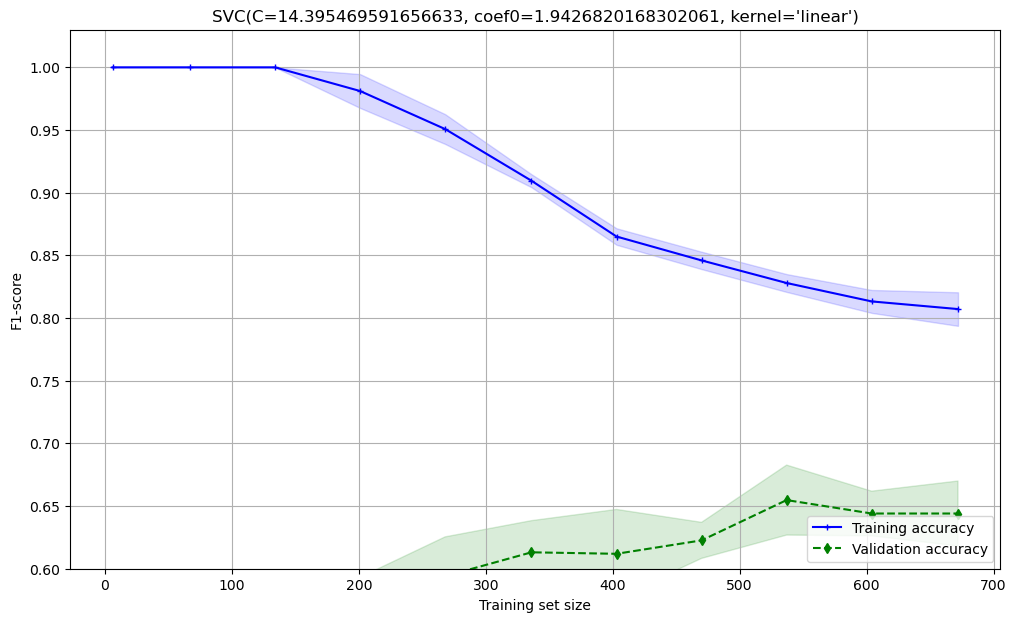

In [ ]:
plot_learning_curve(best_model, X_train, y_train, 'accuracy')

### Performance in function of train/test ratio

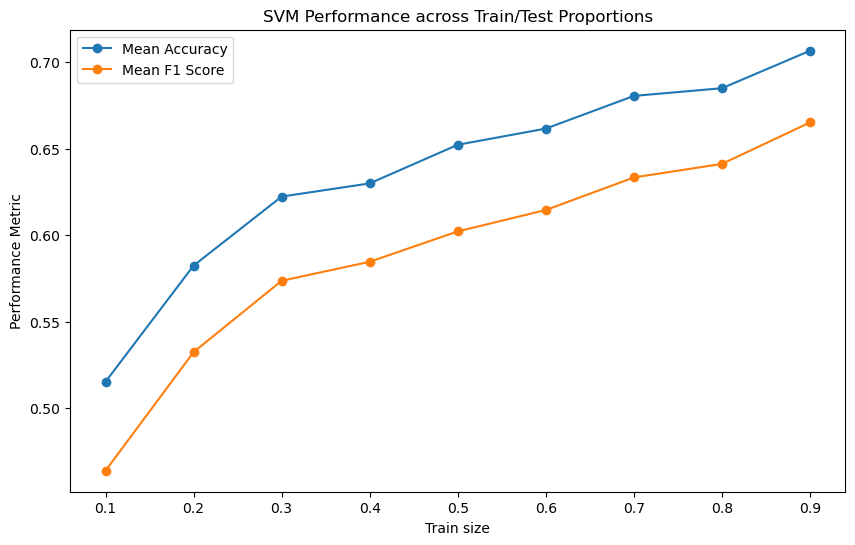

In [ ]:
# Define different train/test proportions to explore
train_test_proportions = np.arange(0.1, 1.0, 0.1)

# Lists to store performance metrics
mean_accuracies = []
mean_f1_scores = []

# Evaluate SVM for each train/test proportion
for proportion in train_test_proportions:
    # Create train/test split with the specified proportion
    sss = StratifiedShuffleSplit(n_splits=5, test_size=1 - proportion, random_state=42)
    
    # Perform cross-validation
    accuracies = cross_val_score(best_model, X, y, cv=sss, scoring='accuracy')
    f1_scores = cross_val_score(best_model, X, y, cv=sss, scoring='f1_macro')
    
    # Append mean results to the lists
    mean_accuracies.append(np.mean(accuracies))
    mean_f1_scores.append(np.mean(f1_scores))

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_test_proportions, mean_accuracies, label='Mean Accuracy', marker='o')
plt.plot(train_test_proportions, mean_f1_scores, label='Mean F1 Score', marker='o')

plt.xlabel('Train size')
plt.ylabel('Performance Metric')
plt.title('SVM Performance across Train/Test Proportions')
plt.legend()
plt.show()

### Confusion Matrix

Training Set Confusion Matrix

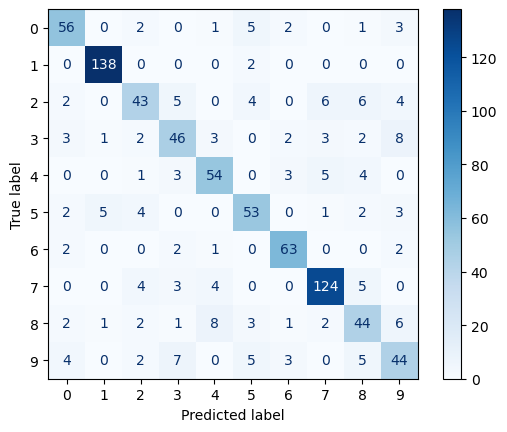

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, cmap=plt.cm.Blues)
plt.show()

Test Set Confusion Matrix


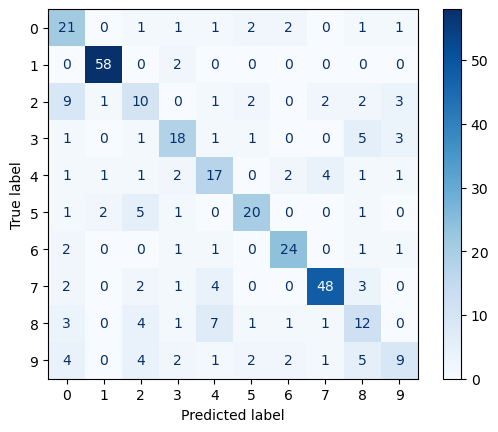

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap=plt.cm.Blues)
plt.show()

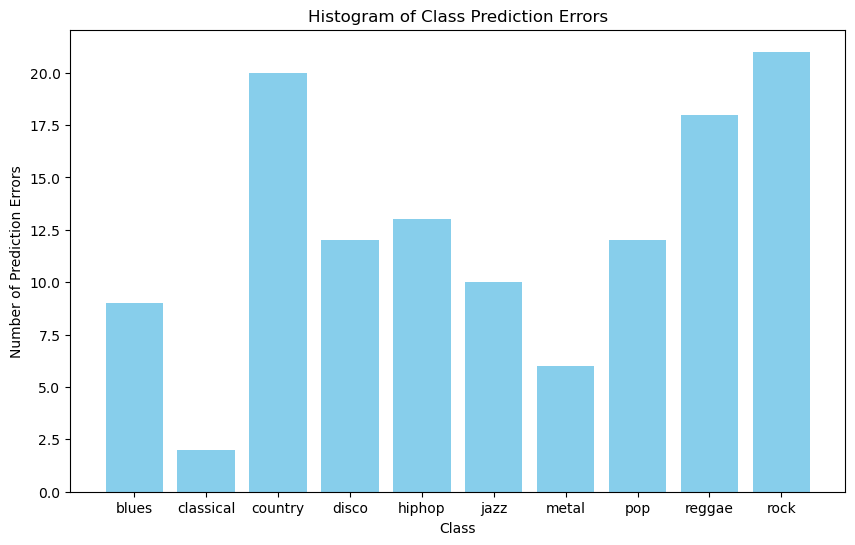

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Calculate the number of errors for each class
class_errors = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
class_labels = [name_mapping[i] for i in np.arange(len(class_errors))]

# Plot a histogram of class prediction errors
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_errors, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Prediction Errors')
plt.title('Histogram of Class Prediction Errors')
plt.show()

In conclusion the model has a general accuracy of around 0.66 which can grow up to 0.70 with a bigger training dataset and a weighted f1 of around 0.65.
The model performs better on the most present genres of the dataset, which are 'classical' and 'pop', this trend couldn't be completely removed with any sampling technique due to the limited dimension of the dataset used. Instead, the genres 'country', 'rock' and 'reggae' seem to be those causing most problems to the model.
I preferred this model over better performing models due to its lower overfitting trend.
Probably with a dataset of bigger dimension the performance of the model can be substantially improved .
It is important to remember, though, that music genres are not naturally defined, this means that an audio track cannot be associated to a genre with a probability of 1. Moreover, often genres blend together, it could be said that musical genres are organized in a continuous multi-dimensional spectrum rather than being a discrete variable .
These issues may reduce the possiblities of the model to reach a much better performance.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=01e7ee1b-10bd-4862-9115-fdce25777dc4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>